Available datasets: ['delta_psi_maps', 'images_clean', 'images_rgb', 'is_detectable', 'residual_l2_null', 'residual_l2_sub', 'snr_proxy', 'source_x', 'source_y', 'subhalo_mass', 'subhalo_x', 'subhalo_y']
images_rgb             -> shape (10000, 40, 40, 3), dtype float32
images_clean           -> shape (10000, 40, 40, 3), dtype float32
delta_psi_maps         -> shape (10000, 40, 40), dtype float32
subhalo_mass           -> shape (10000,), dtype float32
subhalo_x              -> shape (10000,), dtype float32
subhalo_y              -> shape (10000,), dtype float32
source_x               -> shape (10000,), dtype float32
source_y               -> shape (10000,), dtype float32
snr_proxy              -> shape (10000,), dtype float32
is_detectable          -> shape (10000,), dtype int8

Attributes:
 - H0_Om0_Ob0: [7.0e+01 3.0e-01 4.8e-02]
 - N_samples: 10000
 - bands: g,r,i
 - description: Dataset LSST-like RGB (solo subhalo, FAST, thr=10.00): images_rgb/clean guardadas con sqrt-stretch opciona

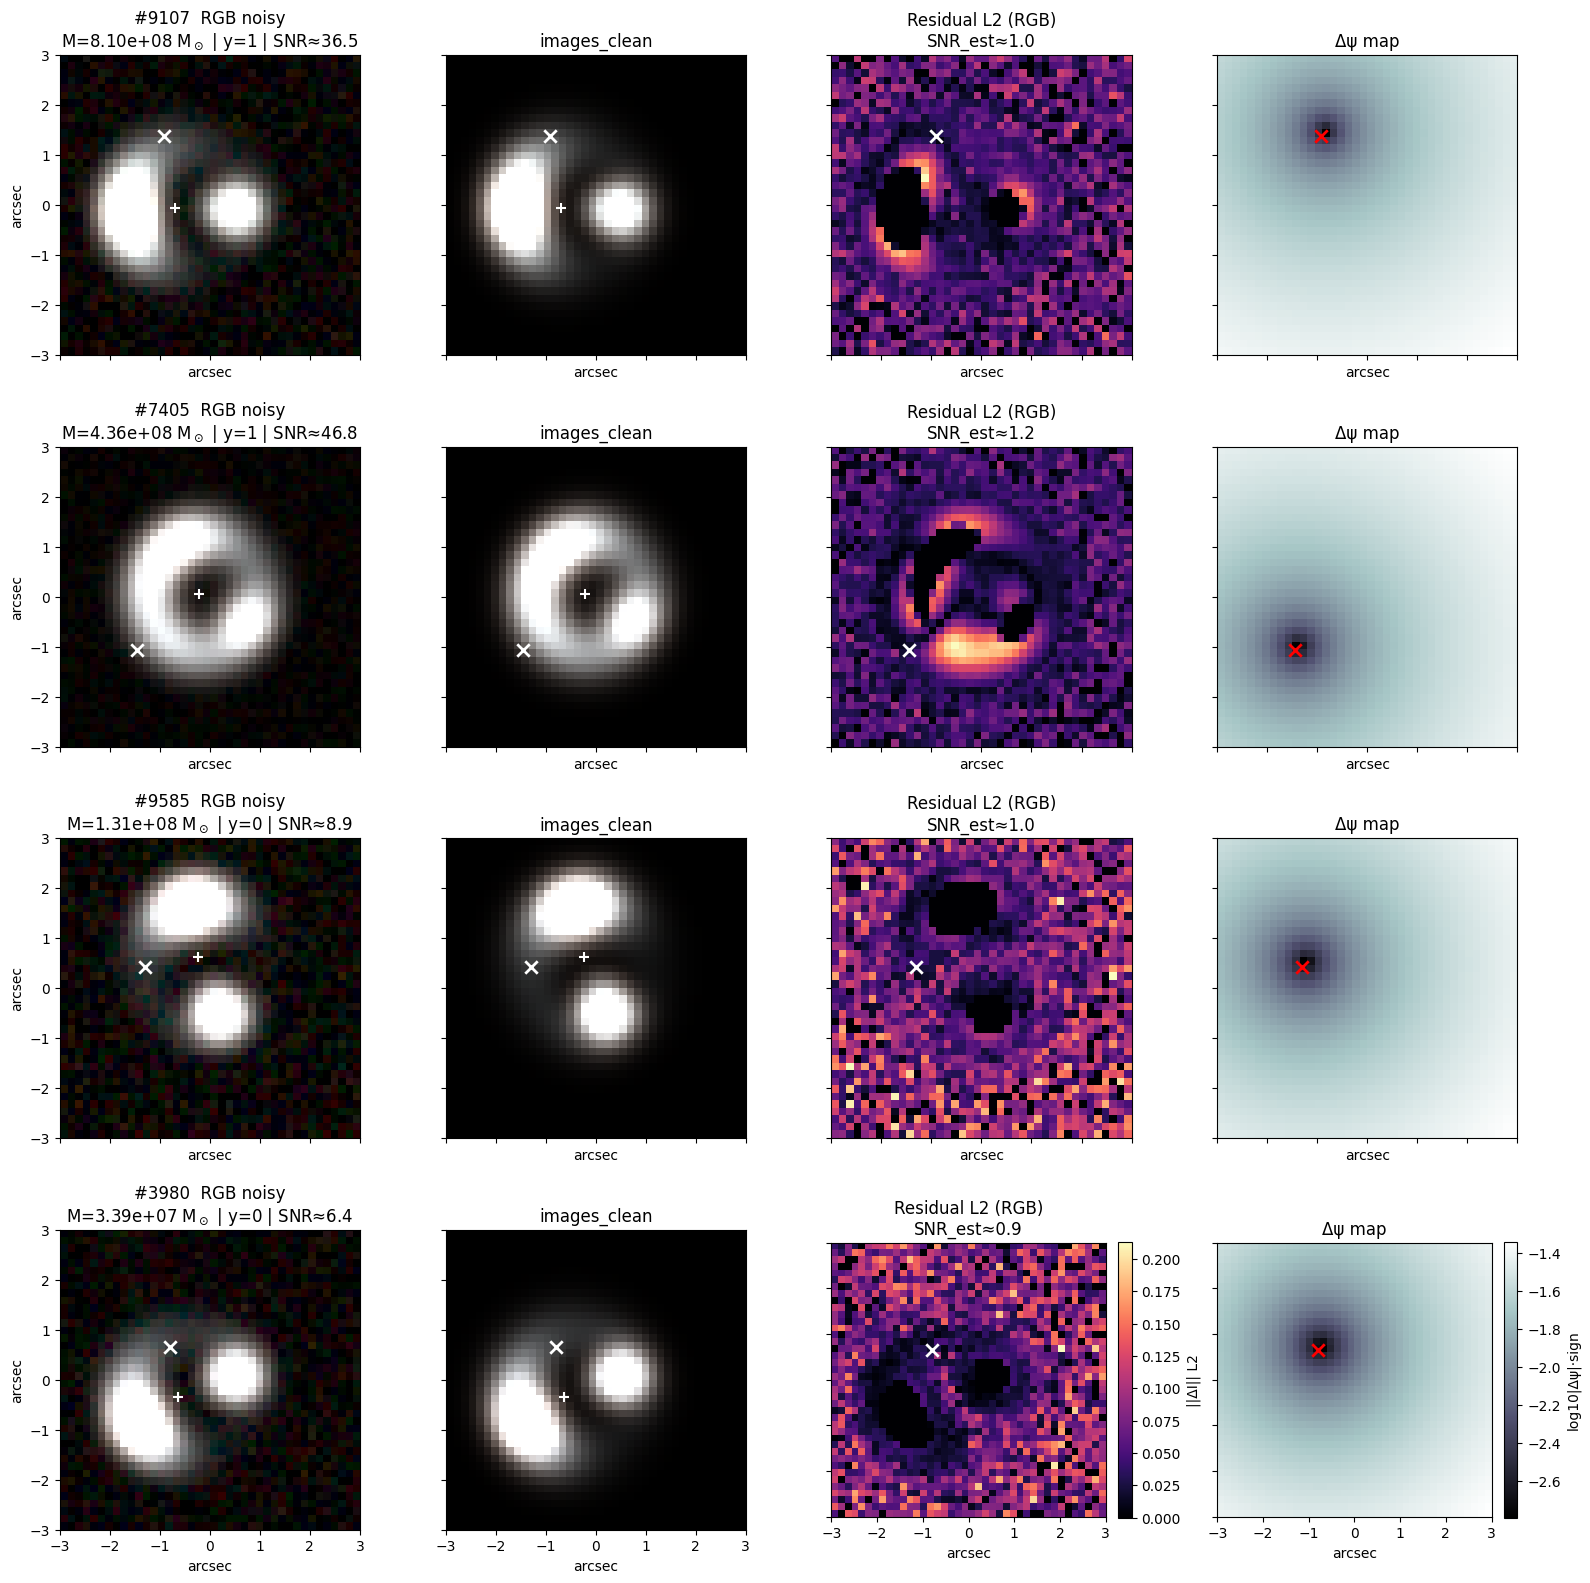


Fracción y=1 (positivos) = 0.589   [is_detectable]


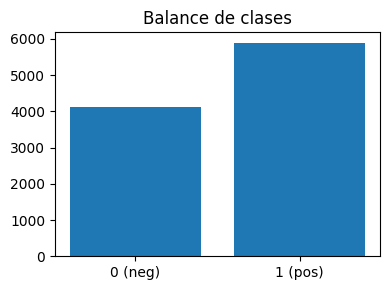

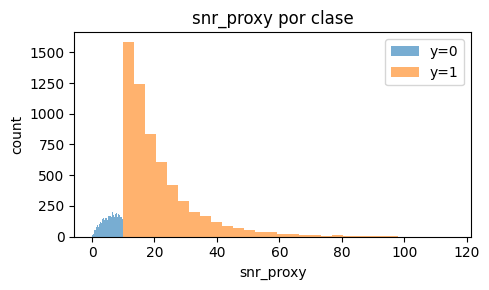

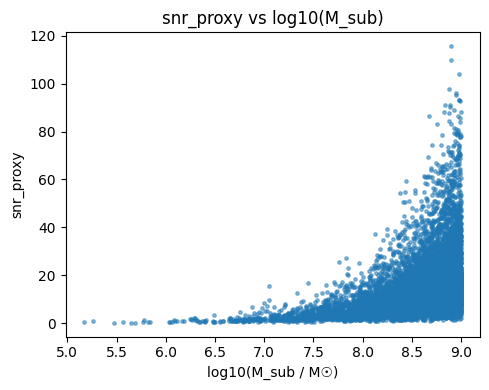

In [133]:
# explore_lsst_lensing_h5.py
import numpy as np
import h5py
import matplotlib.pyplot as plt

# =========================
# Helpers
# =========================
def _pick_key(group, *candidates):
    """Devuelve el primer nombre existente en el HDF5 de la lista de candidatos."""
    for k in candidates:
        if k in group:
            return k
    return None

def _pick_attr(attrs, name, default=None):
    try:
        return float(attrs[name])
    except Exception:
        return default

def _get_extent(f):
    """extent=[xmin,xmax,ymin,ymax] (arcsec) para imshow."""
    # intenta con stamp_size; si no, con pixel_scale
    if 'stamp_size_arcsec' in f.attrs:
        L = float(f.attrs['stamp_size_arcsec'])
        return [-L/2, L/2, -L/2, L/2]
    # infiere con forma y pixel_scale
    if 'images_rgb' in f:
        ny, nx = f['images_rgb'].shape[1:3]
    else:
        # fallback muy defensivo
        ny = nx = 40
    ps = _pick_attr(f.attrs, 'pixel_scale_arcsec', 0.15)
    Lx, Ly = nx*ps, ny*ps
    return [-Lx/2, Lx/2, -Ly/2, Ly/2]

def _residual_l2_rgb(img_a, img_b):
    """L2 por píxel en 3 canales (H,W). img_a e img_b deben tener mismo espacio."""
    R = img_a - img_b
    return np.sqrt((R*R).sum(axis=-1))

def _estimate_sigma_from_corners(img_rgb, corner=6):
    """Sigma por banda desde esquinas; sigma_eff para L2 RGB."""
    H, W, C = img_rgb.shape
    c = min(corner, H//4, W//4)
    corners = [img_rgb[:c,:c,:], img_rgb[:c,-c:,:], img_rgb[-c:,:c,:], img_rgb[-c:,-c:,:]]
    stack = np.concatenate([x.reshape(-1, C) for x in corners], axis=0)
    sigma_per_band = np.std(stack, axis=0)
    sigma_eff = float(np.sqrt((sigma_per_band**2).sum()))
    return sigma_per_band, sigma_eff

def _class_labels(f):
    """
    Devuelve vector y (0/1) y el nombre del dataset usado para ello.
    Prioridad: 'has_subhalo' -> 'is_detectable' -> 'label'/'y'
    """
    ykey = _pick_key(f, 'has_subhalo', 'is_detectable', 'label', 'y')
    if ykey is None:
        return None, None
    y = f[ykey][:].astype(np.int64).ravel()
    return y, ykey

def _pick_clean_like(f):
    """
    Elige un 'clean' compatible con images_rgb para hacer residuales.
    Preferencias:
      1) 'images_clean' (noisy sin subhalo, misma semilla A)
      2) 'images_no_sub' o 'images_rgb_no_sub'
      3) 'images_clean_noiseless' (funciona si escalado es igual)
    Si no encuentra nada, devuelve None.
    """
    k = _pick_key(f, 'images_clean', 'images_no_sub', 'images_rgb_no_sub', 'images_clean_noiseless')
    return k

# =========================
# Explorador
# =========================
h5_path = 'LSST_Mmxy_onlySubhalo_1e4to1e9_noiselessClean_fast_thr3p5.h5'
   # <-- cambia si es otro archivo

with h5py.File(h5_path, 'r') as f:
    # ---- inventario
    print("Available datasets:", list(f.keys()))
    for k in ['images_rgb','images_clean','images_no_sub','images_rgb_no_sub','images_clean_noiseless',
              'delta_psi_maps','subhalo_mass','subhalo_x','subhalo_y',
              'source_x','source_y','snr_proxy','is_detectable','has_subhalo','vis_mask']:
        if k in f:
            print(f"{k:22s} -> shape {f[k].shape}, dtype {f[k].dtype}")
    print("\nAttributes:")
    for k,v in f.attrs.items():
        print(f" - {k}: {v}")

    # ---- claves principales
    k_rgb  = 'images_rgb'
    k_dpsi = _pick_key(f, 'delta_psi_maps')
    k_clean = _pick_clean_like(f)    # puede ser None
    y, ykey = _class_labels(f)

    if k_rgb not in f:
        raise RuntimeError("No encuentro 'images_rgb' en el archivo.")
    X = f[k_rgb]
    N, H, W, C = X.shape

    # ---- partición de ejemplos a mostrar (estratificada si hay y)
    if y is not None:
        idx_pos = np.where(y==1)[0]
        idx_neg = np.where(y==0)[0]
        print(f"\nTotal: {N}  |  Positivos (y=1): {idx_pos.size}  |  Negativos (y=0): {idx_neg.size}  |  label={ykey}")
        pick = []
        if idx_pos.size: pick += list(np.random.choice(idx_pos, size=min(2, idx_pos.size), replace=False))
        if idx_neg.size: pick += list(np.random.choice(idx_neg, size=min(2, idx_neg.size), replace=False))
        if not pick:     pick  = list(np.random.choice(np.arange(N), size=4, replace=False))
        sample_indices = np.array(pick)
    else:
        print("\nNo encontré etiquetas de clase; muestro 4 ejemplos al azar.")
        sample_indices = np.random.choice(np.arange(N), size=4, replace=False)

    print("Plotting samples:", sample_indices.tolist())

    # ---- paneles por ejemplo
    extent = _get_extent(f)
    ncols_base = 2   # RGB noisy + (clean si hay)
    if k_clean is not None: ncols_base += 1  # para residual
    if k_dpsi is not None: ncols_base += 1   # para Δψ
    if 'vis_mask' in f:    ncols_base += 1

    fig, axes = plt.subplots(len(sample_indices), ncols_base, figsize=(4*ncols_base, 4*len(sample_indices)),
                             sharex=True, sharey=True)
    if len(sample_indices) == 1:
        axes = np.expand_dims(axes, 0)

    for row, idx in enumerate(sample_indices):
        img_rgb = X[idx]  # (H,W,3)
        mass = f['subhalo_mass'][idx] if 'subhalo_mass' in f else np.nan
        x_sub = f['subhalo_x'][idx] if 'subhalo_x' in f else np.nan
        y_sub = f['subhalo_y'][idx] if 'subhalo_y' in f else np.nan
        x_src = f['source_x'][idx] if 'source_x' in f else np.nan
        y_src = f['source_y'][idx] if 'source_y' in f else np.nan
        snr_saved = f['snr_proxy'][idx] if 'snr_proxy' in f else np.nan
        ytxt = int(y[idx]) if y is not None else None

        col = 0
        # 1) RGB noisy
        ax = axes[row, col]; col += 1
        ax.imshow(img_rgb, origin='lower', extent=extent)
        if np.isfinite(x_sub) and np.isfinite(y_sub): ax.scatter([x_sub],[y_sub], marker='x', s=80, lw=2, color='w')
        if np.isfinite(x_src) and np.isfinite(y_src): ax.scatter([x_src],[y_src], marker='+', s=60, lw=1.5, color='w')
        tit = f"#{idx}  RGB noisy\nM={mass:.2e} M$_\\odot$"
        if ytxt is not None: tit += f" | y={ytxt}"
        if np.isfinite(snr_saved): tit += f" | SNR≈{snr_saved:.1f}"
        ax.set_title(tit); ax.set_xlabel("arcsec"); ax.set_ylabel("arcsec")

        # 2) clean (si existe)
        img_clean = None
        if k_clean is not None:
            img_clean = f[k_clean][idx]
            ax = axes[row, col]; col += 1
            ax.imshow(img_clean, origin='lower', extent=extent)
            if np.isfinite(x_sub) and np.isfinite(y_sub): ax.scatter([x_sub],[y_sub], marker='x', s=80, lw=2, color='w')
            if np.isfinite(x_src) and np.isfinite(y_src): ax.scatter([x_src],[y_src], marker='+', s=60, lw=1.5, color='w')
            ax.set_title(f"{k_clean}"); ax.set_xlabel("arcsec")

        # 3) residual L2 (si clean disponible y misma escala)
        if img_clean is not None and img_clean.shape == img_rgb.shape:
            R2 = _residual_l2_rgb(img_rgb, img_clean)
            _, sigma_eff = _estimate_sigma_from_corners(img_rgb)
            snr_est = float(np.nanmean(R2) / (sigma_eff + 1e-12))
            ax = axes[row, col]; col += 1
            imR = ax.imshow(R2, origin='lower', extent=extent, cmap='magma')
            if np.isfinite(x_sub) and np.isfinite(y_sub): ax.scatter([x_sub],[y_sub], marker='x', s=80, lw=2, color='w')
            ax.set_title(f"Residual L2 (RGB)\nSNR_est≈{snr_est:.1f}")
            ax.set_xlabel("arcsec")
            if row == len(sample_indices)-1:
                cbar = plt.colorbar(imR, ax=ax, fraction=0.046, pad=0.04)
                cbar.ax.set_ylabel("||ΔI|| L2")

        # 4) Δψ (si existe)
        if k_dpsi is not None:
            dpsi = f[k_dpsi][idx]
            ax = axes[row, col]; col += 1
            im = ax.imshow(dpsi, origin='lower', extent=extent, cmap='bone')
            if np.isfinite(x_sub) and np.isfinite(y_sub): ax.scatter([x_sub],[y_sub], marker='x', s=80, lw=2, color='r')
            ax.set_title("Δψ map"); ax.set_xlabel("arcsec")
            if row == len(sample_indices)-1:
                cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
                cbar.ax.set_ylabel("log10|Δψ|·sign")

        # 5) vis_mask (si existe)
        if 'vis_mask' in f:
            vis = f['vis_mask'][idx]
            ax = axes[row, col]; col += 1
            ax.imshow(vis, origin='lower', extent=extent, cmap='viridis')
            ax.set_title("vis_mask"); ax.set_xlabel("arcsec")

    plt.tight_layout(); plt.show()

    # =========================
    # Diagnósticos globales
    # =========================
    if y is not None:
        frac = y.mean()
        print(f"\nFracción y=1 (positivos) = {frac:.3f}   [{ykey}]")

        # Hist balance
        plt.figure(figsize=(4,3))
        counts = [np.sum(y==0), np.sum(y==1)]
        plt.bar([0,1], counts, tick_label=['0 (neg)','1 (pos)'])
        plt.title("Balance de clases"); plt.tight_layout(); plt.show()

        # SNR proxy por clase (si existe)
        if 'snr_proxy' in f:
            snr = f['snr_proxy'][:]
            plt.figure(figsize=(5,3))
            plt.hist(snr[y==0], bins=30, alpha=.6, label='y=0')
            plt.hist(snr[y==1], bins=30, alpha=.6, label='y=1')
            plt.xlabel("snr_proxy"); plt.ylabel("count")
            plt.title("snr_proxy por clase"); plt.legend(); plt.tight_layout(); plt.show()

        # Masa vs snr_proxy (si ambos existen)
        if 'subhalo_mass' in f:
            m = f['subhalo_mass'][:]
            plt.figure(figsize=(5,4))
            if 'snr_proxy' in f:
                snr = f['snr_proxy'][:]
                plt.scatter(np.log10(np.clip(m,1,1e12)), snr, s=6, alpha=.5)
                plt.xlabel("log10(M_sub / M☉)"); plt.ylabel("snr_proxy")
                plt.title("snr_proxy vs log10(M_sub)")
            else:
                plt.hist(np.log10(np.clip(m[y==1],1,1e12)), bins=30, alpha=.6, label='y=1')
                plt.hist(np.log10(np.clip(m[y==0],1,1e12)), bins=30, alpha=.6, label='y=0')
                plt.xlabel("log10(M_sub / M☉)"); plt.ylabel("count"); plt.legend()
                plt.title("Distribución de masas por clase")
            plt.tight_layout(); plt.show()


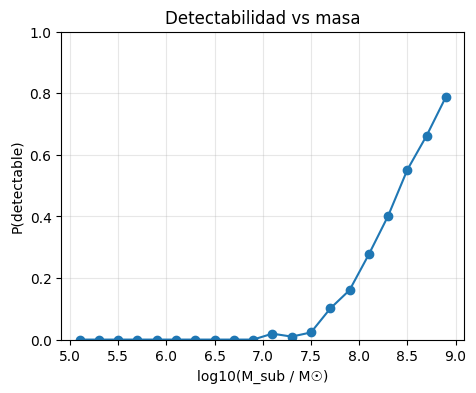

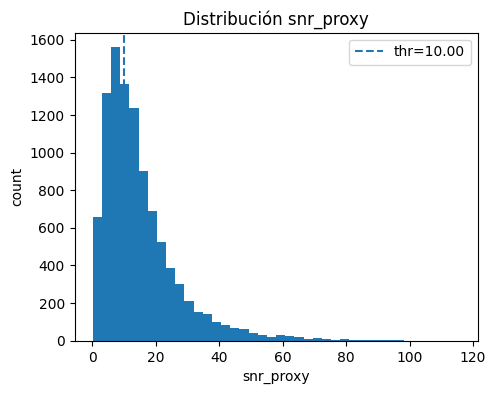

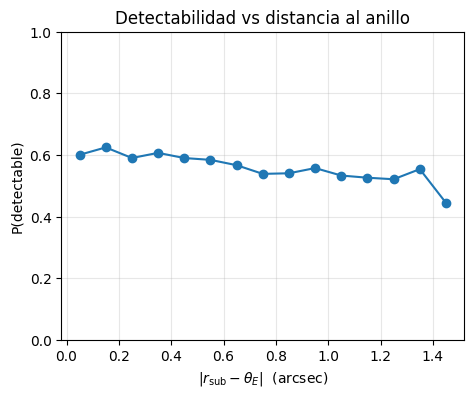

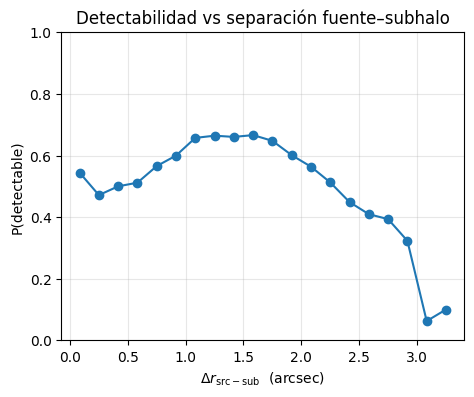

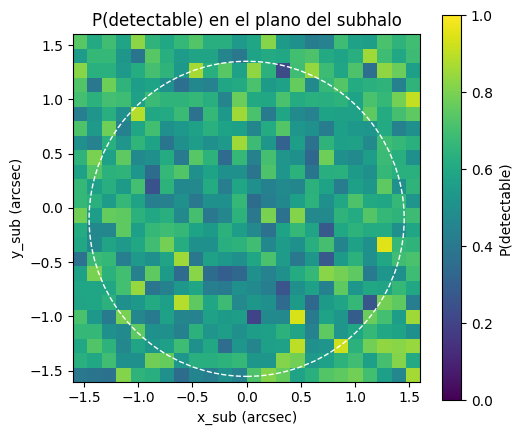

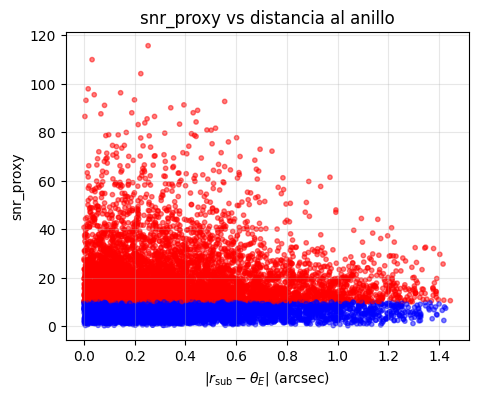

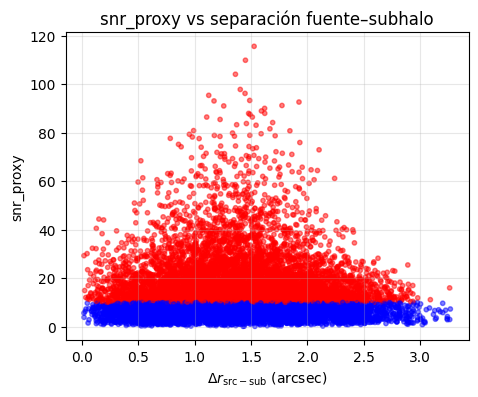

Corr(snr, |r_sub - theta_E|) = -0.09728233516216278
Corr(snr, Δr_src-sub)       = -0.03842860832810402
Corr(snr, log10(M))         = 0.40631866455078125


In [134]:
import numpy as np, h5py, matplotlib.pyplot as plt

# ====== parámetros ======
h5_path = 'LSST_Mmxy_onlySubhalo_1e4to1e9_noiselessClean_fast_thr3p5.h5'

# ---- Cargar arrays y attrs dentro del with ----
with h5py.File(h5_path, 'r') as f:
    m    = f['subhalo_mass'][:]                  # (N,)
    snr  = f['snr_proxy'][:]                     # (N,)
    y    = f['is_detectable'][:].astype(bool)    # (N,)
    xs, ys = f['subhalo_x'][:], f['subhalo_y'][:]
    # source_x/y pueden no existir en algunos sets
    xq = f['source_x'][:] if 'source_x' in f else np.full_like(xs, np.nan)
    yq = f['source_y'][:] if 'source_y' in f else np.full_like(ys, np.nan)
    # Guarda theta_E (si no existe, usa default)
    theta_E = float(f.attrs.get('theta_E_main', 1.452))
    # (opcional) umbral usado en generación
    snr_thr = float(f.attrs.get('snr_thresh_noisy', np.nan))

# ====== features geométricas ======
qmass = np.log10(np.clip(m, 1, None))
r_sub = np.hypot(xs, ys)
r_src = np.hypot(xq, yq)
dr_src_sub  = np.hypot(xs - xq, ys - yq)          # puede tener NaNs si no hay source_x/y
dr_sub_ring = np.abs(r_sub - theta_E)

# ====== helper para probabilidad binned ======
def prob_binned(x, y_bool, bins):
    mids, frac, n = [], [], []
    for a, b in zip(bins[:-1], bins[1:]):
        sel = (x >= a) & (x < b) & np.isfinite(x)
        if sel.sum():
            mids.append((a + b) / 2)
            frac.append(y_bool[sel].mean())
            n.append(sel.sum())
    return np.array(mids), np.array(frac), np.array(n)

# ====== 1) P(det|masa) ======
bins_mass = np.linspace(4, 9, 26)
mids, frac, cnt = prob_binned(qmass, y, bins_mass)
plt.figure(figsize=(5.2,4))
plt.plot(mids, frac, marker='o')
plt.ylim(0,1); plt.grid(True, alpha=.3)
plt.xlabel('log10(M_sub / M☉)'); plt.ylabel('P(detectable)')
plt.title('Detectabilidad vs masa'); plt.show()

# ====== 2) Hist de SNR ======
plt.figure(figsize=(5.2,4))
plt.hist(snr[np.isfinite(snr)], bins=40)
if np.isfinite(snr_thr): plt.axvline(snr_thr, ls='--', label=f'thr={snr_thr:.2f}')
plt.xlabel('snr_proxy'); plt.ylabel('count'); 
plt.title('Distribución snr_proxy'); 
if np.isfinite(snr_thr): plt.legend()
plt.show()

# ====== 3) P(det||r_sub - theta_E|) ======
bins_ring = np.linspace(0, 2.0, 21)  # arcsec
mids, frac, cnt = prob_binned(dr_sub_ring, y, bins_ring)
plt.figure(figsize=(5.2,4))
plt.plot(mids, frac, marker='o')
plt.ylim(0,1); plt.grid(True, alpha=.3)
plt.xlabel(r'$|r_{\rm sub}-\theta_E|$  (arcsec)')
plt.ylabel('P(detectable)')
plt.title('Detectabilidad vs distancia al anillo'); 
plt.show()

# ====== 4) P(det|Δr_src-sub) ======
if np.isfinite(dr_src_sub).any():
    bins_sep = np.linspace(0, 4.0, 25)
    mids, frac, cnt = prob_binned(dr_src_sub, y, bins_sep)
    plt.figure(figsize=(5.2,4))
    plt.plot(mids, frac, marker='o')
    plt.ylim(0,1); plt.grid(True, alpha=.3)
    plt.xlabel(r'$\Delta r_{\rm src-sub}$  (arcsec)')
    plt.ylabel('P(detectable)')
    plt.title('Detectabilidad vs separación fuente–subhalo'); 
    plt.show()

# ====== 5) Mapa 2D de P(det) en (x_sub,y_sub) ======
xb = np.linspace(-1.6, 1.6, 25)
yb = np.linspace(-1.6, 1.6, 25)
H_det   = np.zeros((len(yb)-1, len(xb)-1), dtype=float)
H_count = np.zeros_like(H_det)
ix = np.digitize(xs, xb) - 1
iy = np.digitize(ys, yb) - 1
valid = (ix>=0)&(ix<H_det.shape[1])&(iy>=0)&(iy<H_det.shape[0])
for i, j, yy in zip(iy[valid], ix[valid], y[valid]):
    H_count[i,j] += 1
    H_det[i,j]   += float(yy)
P2 = np.where(H_count>0, H_det/H_count, np.nan)

plt.figure(figsize=(5.6,5))
im = plt.imshow(P2, origin='lower',
                extent=[xb[0], xb[-1], yb[0], yb[-1]],
                vmin=0, vmax=1, cmap='viridis')
plt.colorbar(im, label='P(detectable)')
plt.xlabel('x_sub (arcsec)'); plt.ylabel('y_sub (arcsec)')
plt.title('P(detectable) en el plano del subhalo')
# círculo ≈ anillo de Einstein
circle = plt.Circle((0.0,-0.1), theta_E, color='w', fill=False, lw=1, ls='--')
plt.gca().add_patch(circle)
plt.show()

# ====== 6) Dispersión SNR vs métricas geométricas ======
plt.figure(figsize=(5.2,4))
plt.scatter(dr_sub_ring, snr, s=10, alpha=0.5, c=y, cmap='bwr', vmin=0, vmax=1)
plt.xlabel(r'$|r_{\rm sub}-\theta_E|$ (arcsec)'); plt.ylabel('snr_proxy')
plt.title('snr_proxy vs distancia al anillo'); plt.grid(True, alpha=.3); plt.show()

if np.isfinite(dr_src_sub).any():
    plt.figure(figsize=(5.2,4))
    plt.scatter(dr_src_sub, snr, s=10, alpha=0.5, c=y, cmap='bwr', vmin=0, vmax=1)
    plt.xlabel(r'$\Delta r_{\rm src-sub}$ (arcsec)'); plt.ylabel('snr_proxy')
    plt.title('snr_proxy vs separación fuente–subhalo'); plt.grid(True, alpha=.3); plt.show()

# ====== 7) Correlaciones rápidas ======
def corr(a,b):
    sel = np.isfinite(a) & np.isfinite(b)
    if sel.sum() < 3: return np.nan
    a = (a[sel] - a[sel].mean())/(a[sel].std()+1e-12)
    b = (b[sel] - b[sel].mean())/(b[sel].std()+1e-12)
    return float(np.mean(a*b))

print("Corr(snr, |r_sub - theta_E|) =", corr(snr, dr_sub_ring))
print("Corr(snr, Δr_src-sub)       =", corr(snr, dr_src_sub))
print("Corr(snr, log10(M))         =", corr(snr, qmass))


In [135]:

import h5py, numpy as np
import torch
from sklearn.model_selection import train_test_split

# ---------- Config ----------
H5_PATH = 'LSST_Mmxy_onlySubhalo_1e4to1e9_noiselessClean_fast_thr3p5.h5'
RANDOM_STATE = 42
TRAIN_FRAC, VAL_FRAC, TEST_FRAC = 0.6, 0.2, 0.2

assert abs((TRAIN_FRAC + VAL_FRAC + TEST_FRAC) - 1.0) < 1e-6
np.random.seed(RANDOM_STATE)

# ---------- Carga ----------
with h5py.File(H5_PATH, "r") as f:
    X = f["images_rgb"][:]                     # (N, H, W, 3)
    y = f["is_detectable"][:].astype(int)      # (N,)
    maxval = f["images_rgb"].attrs.get("maxval", 1.0)
    print("X:", X.shape, X.dtype, "| y:", y.shape, y.dtype)

# ---------- Normalización y formato (C,H,W)
X = (X.astype(np.float32) / maxval).transpose(0, 3, 1, 2)  # (N,3,40,40)
y = y.astype(np.float32)  # Para BCELoss

# ---------- Split estratificado ----------
idx_all = np.arange(len(y))
idx_train, idx_rest, y_train, y_rest = train_test_split(
    idx_all, y, test_size=(1.0 - TRAIN_FRAC), stratify=y, random_state=RANDOM_STATE
)
val_size = VAL_FRAC / (VAL_FRAC + TEST_FRAC)
idx_val, idx_test, y_val, y_test = train_test_split(
    idx_rest, y_rest, test_size=(1.0 - val_size), stratify=y_rest, random_state=RANDOM_STATE
)

# ---------- Tensores listos para TensorDataset ----------
X_train, y_train = torch.tensor(X[idx_train]), torch.tensor(y[idx_train])
X_val,   y_val   = torch.tensor(X[idx_val]),   torch.tensor(y[idx_val])
X_test,  y_test  = torch.tensor(X[idx_test]),  torch.tensor(y[idx_test])

print("Arrays listos:")
print("  X_train:", X_train.shape, "| y_train:", y_train.shape)
print("  X_val:  ", X_val.shape,   "| y_val:",   y_val.shape)
print("  X_test: ", X_test.shape,  "| y_test:",  y_test.shape)

# (opcional) guardar índices
np.savez_compressed(
    H5_PATH.replace(".h5", "_split_idx.npz"),
    train=idx_train, val=idx_val, test=idx_test
)



X: (10000, 40, 40, 3) float32 | y: (10000,) int64
Arrays listos:
  X_train: torch.Size([6000, 3, 40, 40]) | y_train: torch.Size([6000])
  X_val:   torch.Size([2000, 3, 40, 40]) | y_val: torch.Size([2000])
  X_test:  torch.Size([2000, 3, 40, 40]) | y_test: torch.Size([2000])


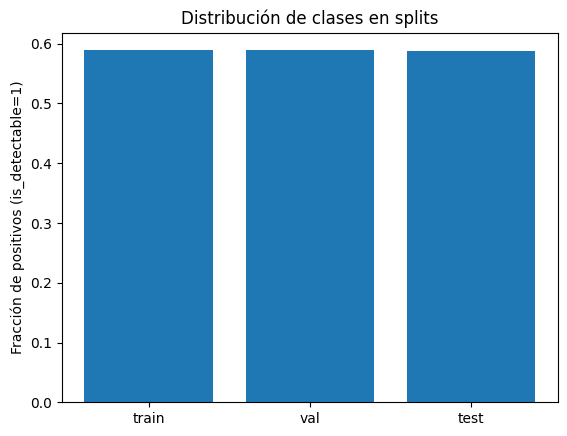

In [136]:
import matplotlib.pyplot as plt
import torch

# Aseguramos que estén en float para obtener proporciones con .mean()
train_pos_frac = y_train.float().mean().item()
val_pos_frac   = y_val.float().mean().item()
test_pos_frac  = y_test.float().mean().item()

plt.bar(['train', 'val', 'test'], [train_pos_frac, val_pos_frac, test_pos_frac])
plt.ylabel("Fracción de positivos (is_detectable=1)")
plt.title("Distribución de clases en splits")
plt.show()


In [137]:

# import torch
# from torch.utils.data import Dataset
# import h5py

# class LensingDataset(Dataset):
#     def __init__(self, h5_path, indices, transform=None):
#         self.h5_path = h5_path
#         self.indices = indices
#         self.transform = transform

#         # Abrimos el archivo en modo de solo lectura
#         self.file = h5py.File(self.h5_path, 'r')
#         self.X = self.file['images_rgb']
#         self.y = self.file['is_detectable']

#     def __len__(self):
#         return len(self.indices)

#     def __getitem__(self, idx):
#         real_idx = self.indices[idx]
#         img = self.X[real_idx]        # (H,W,3)
#         label = self.y[real_idx]      # 0 o 1

#         # Normalización simple
#         img = img.astype('float32') / self.X.attrs.get('maxval', 1.0)
#         img = img.transpose(2, 0, 1)  # PyTorch: (C, H, W)

#         img_tensor = torch.tensor(img, dtype=torch.float32)
#         label_tensor = torch.tensor(label, dtype=torch.float32)

#         return img_tensor, label_tensor

#     def close(self):
#         self.file.close()


In [138]:
# import numpy as np
# from torch.utils.data import DataLoader

# # ---------- Config ----------
# h5_path = 'LSST_Mmxy_noisyResidual_paired_withNoSub.h5'
# split_path = h5_path.replace('.h5', '_split_idx.npz')
# batch_size = 32

# # ---------- Cargar índices ----------
# splits = np.load(split_path)
# idx_train = splits['train']
# idx_val   = splits['val']
# idx_test  = splits['test']

# # ---------- Instanciar datasets ----------
# ds_train = LensingDataset(h5_path, idx_train)
# ds_val   = LensingDataset(h5_path, idx_val)
# ds_test  = LensingDataset(h5_path, idx_test)

# # ---------- Crear DataLoaders ----------
# dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
# dl_val   = DataLoader(ds_val, batch_size=batch_size)
# dl_test  = DataLoader(ds_test, batch_size=batch_size)

from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import torch

# ---------- Config ----------
batch_size = 256  # puedes ajustarlo según tu GPU
on_cuda = torch.cuda.is_available()

# ---------- Cargar splits ----------
h5_path = 'LSST_Mmxy_noisyResidual_paired_withNoSub.h5'
split_path = h5_path.replace('.h5', '_split_idx.npz')
splits = np.load(split_path)
idx_train = splits['train']
idx_val   = splits['val']
idx_test  = splits['test']

# ---------- Crear TensorDatasets ----------
train_ds = TensorDataset(X_train, y_train)
val_ds   = TensorDataset(X_val, y_val)
test_ds  = TensorDataset(X_test, y_test)

# ---------- DataLoader configs ----------
loader_kwargs = dict(
    batch_size=batch_size,
    num_workers=4,
    pin_memory=on_cuda,
    persistent_workers=True
)

# ---------- Crear DataLoaders ----------
dl_train = DataLoader(train_ds, shuffle=True, drop_last=True, **loader_kwargs)
dl_val   = DataLoader(val_ds, shuffle=False, drop_last=False, **loader_kwargs)
dl_test  = DataLoader(test_ds, shuffle=False, drop_last=False, **loader_kwargs)


In [139]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    """
    Drop-in de tu SimpleCNN:
    - Conv -> BN -> ReLU
    - MaxPool en dos niveles (40->20->10->5) con un tercer bloque conv
    - Dropout2d para regularizar
    - Global Average Pooling (independiente del tamaño)
    - Sigmoid al final (compatible con BCELoss)
    """
    def __init__(self, p_drop=0.3):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=False)
        self.bn3   = nn.BatchNorm2d(128)

        self.pool  = nn.MaxPool2d(2, 2)     # 40->20->10->5 después del tercer pool
        self.drop1 = nn.Dropout2d(p_drop)
        self.drop2 = nn.Dropout2d(p_drop)

        self.gap   = nn.AdaptiveAvgPool2d(1)  # -> (B,128,1,1)
        self.fc    = nn.Linear(128, 1)        # binario

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # 40->20
        x = self.drop1(x)

        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # 20->10
        x = self.drop2(x)

        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # 10->5
        x = self.gap(x).squeeze(-1).squeeze(-1)         # (B,128)

        x = torch.sigmoid(self.fc(x))                   # (B,1) en [0,1]
        return x.squeeze(-1)                            # (B,)



In [140]:
import torch
import torch.nn as nn
from tqdm import trange
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Entrenando en:", device)

model = SimpleCNN().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)
epochs = 100

train_losses = []
train_accuracies = []
val_accuracies = []
val_aucs = []

outer_bar = trange(1, epochs + 1, desc="Epoch", ncols=130, colour="#EB5E00")

for epoch in outer_bar:
    model.train()
    epoch_loss = 0.0
    preds_train = []
    labels_train = []

    for images, labels in dl_train:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * images.size(0)  # total loss

        preds_train.append(outputs.detach().cpu())
        labels_train.append(labels.cpu())

    train_loss = epoch_loss / len(dl_train.dataset)
    train_preds = torch.cat(preds_train).numpy()
    train_labels = torch.cat(labels_train).numpy()
    train_preds_bin = (train_preds >= 0.5).astype(int)
    train_acc = accuracy_score(train_labels, train_preds_bin)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # ------------------ VALIDACIÓN ------------------
    model.eval()
    preds_val = []
    labels_val = []

    with torch.no_grad():
        for images, labels in dl_val:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            outputs = model(images)
            preds_val.append(outputs.cpu())
            labels_val.append(labels.cpu())

    val_preds = torch.cat(preds_val).numpy()
    val_labels = torch.cat(labels_val).numpy()
    val_preds_bin = (val_preds >= 0.5).astype(int)
    val_acc = accuracy_score(val_labels, val_preds_bin)
    val_auc = roc_auc_score(val_labels, val_preds)

    val_accuracies.append(val_acc)
    val_aucs.append(val_auc)

    outer_bar.set_postfix(
        train_loss=f"{train_loss:.4f}",
        train_acc=f"{train_acc:.3f}",
        val_acc=f"{val_acc:.3f}",
        val_auc=f"{val_auc:.3f}"
    )


Entrenando en: cuda


Epoch: 100%|██████████████████| 100/100 [00:41<00:00,  2.40it/s, train_acc=0.774, train_loss=0.4607, val_acc=0.767, val_auc=0.849]


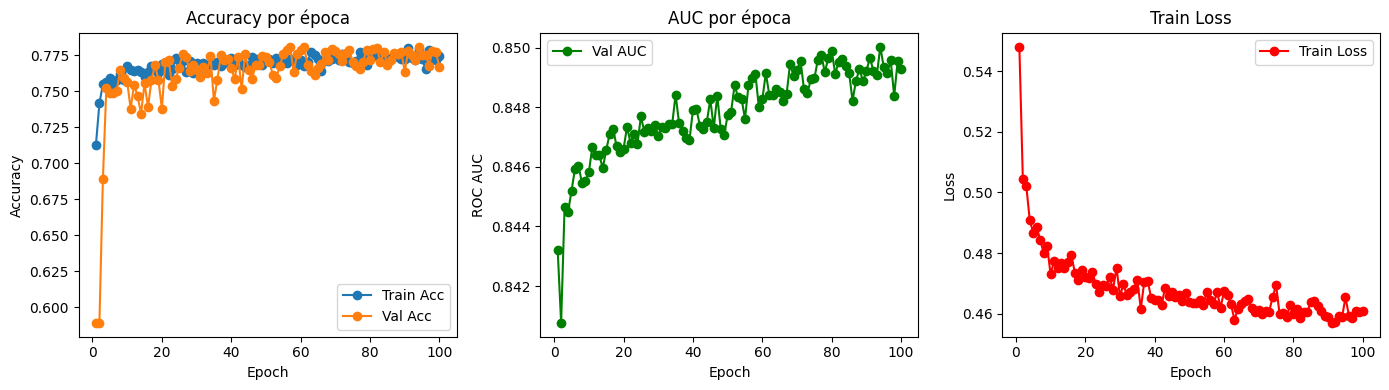

In [141]:
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(14, 4))

# Accuracy
plt.subplot(1, 3, 1)
plt.plot(epochs_range, train_accuracies, label='Train Acc', marker='o')
plt.plot(epochs_range, val_accuracies, label='Val Acc', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy por época")
plt.legend()

# AUC
plt.subplot(1, 3, 2)
plt.plot(epochs_range, val_aucs, label='Val AUC', marker='o', color='green')
plt.xlabel("Epoch")
plt.ylabel("ROC AUC")
plt.title("AUC por época")
plt.legend()

# Loss
plt.subplot(1, 3, 3)
plt.plot(epochs_range, train_losses, label='Train Loss', marker='o', color='red')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train Loss")
plt.legend()

plt.tight_layout()
plt.show()


In [142]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# ---- Evaluar en test ----
model.eval()
test_preds = []
test_labels = []

with torch.no_grad():
    for images, labels in dl_test:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        test_preds.extend(outputs.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

# ---- Binarizar las predicciones ----
test_preds_bin = [1 if p >= 0.5 else 0 for p in test_preds]

# ---- Reporte de clasificación ----
print("=== Classification Report (Test Set) ===")
print(classification_report(test_labels, test_preds_bin, digits=3))

# ---- ROC AUC ----
auc = roc_auc_score(test_labels, test_preds)
print(f"ROC AUC: {auc:.3f}")


=== Classification Report (Test Set) ===
              precision    recall  f1-score   support

         0.0      0.846     0.475     0.609       823
         1.0      0.719     0.940     0.815      1177

    accuracy                          0.749      2000
   macro avg      0.783     0.707     0.712      2000
weighted avg      0.771     0.749     0.730      2000

ROC AUC: 0.844


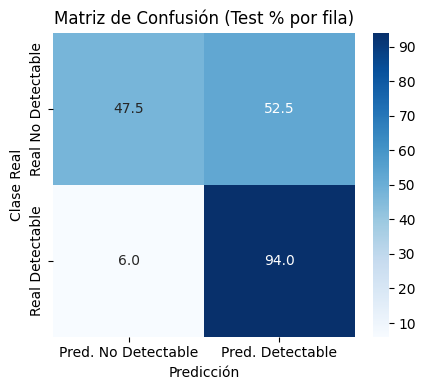

In [143]:
from sklearn.preprocessing import normalize

# Obtener matriz cruda
cm_raw = confusion_matrix(test_labels, test_preds_bin)

# Normalizar por fila (por clase real)
cm_normalized = normalize(cm_raw, norm='l1', axis=1) * 100  # a porcentaje

plt.figure(figsize=(4.5, 4))
sns.heatmap(cm_normalized, annot=True, fmt=".1f", cmap="Blues",
            xticklabels=["Pred. No Detectable", "Pred. Detectable"],
            yticklabels=["Real No Detectable", "Real Detectable"])

plt.title("Matriz de Confusión (Test % por fila)")
plt.xlabel("Predicción")
plt.ylabel("Clase Real")
plt.tight_layout()
plt.show()


In [144]:
# #Save model
torch.save(model.state_dict(), "simple_cnn_weights.pth")


In [147]:
import h5py
import torch
import numpy as np
from tqdm import tqdm

# ===== 1) Modelo =====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleCNN().to(device)
model.load_state_dict(torch.load("simple_cnn_weights.pth", map_location=device))
model.eval()

# ===== 2) Leer H5 original (sin cargar todo si no quieres) =====
H5_PATH = 'LSST_Mmxy_onlySubhalo_1e4to1e9_noiselessClean_fast_thr3p5.h5'
with h5py.File(H5_PATH, 'r') as f:
    N = f['images_rgb'].shape[0]
    # maxval usado en entrenamiento (si existe; si no, será 1.0)
    maxval = float(f['images_rgb'].attrs.get('maxval', 1.0))
    # copia de atributos del archivo
    file_attrs = dict(f.attrs)

# ===== 3) Inferencia por lotes replicando el preprocesado del training =====
batch_size = 128
all_probs = np.empty((N,), dtype=np.float32)

with h5py.File(H5_PATH, 'r') as f:
    for start in tqdm(range(0, N, batch_size)):
        end = min(N, start + batch_size)
        # (B, H, W, 3) -> float32, normalizar como en training, -> (B, 3, H, W)
        x = f['images_rgb'][start:end].astype('float32')
        if maxval != 1.0:
            x = x / maxval
        x = np.transpose(x, (0, 3, 1, 2))

        x_t = torch.from_numpy(x).to(device, non_blocking=True)
        with torch.no_grad():
            p = model(x_t)                    # (B,)
            p = torch.sigmoid(p) if p.ndim == 0 else p  # por si el modelo devolviera logits
        all_probs[start:end] = p.detach().cpu().numpy().astype(np.float32)

# ===== 4) Selección por umbral =====
THRESH = 0.5
sel_idx = np.where(all_probs >= THRESH)[0]
detectable_mask = np.zeros(N, dtype=bool)
detectable_mask[sel_idx] = True

print(f"Detectables: {sel_idx.size} / {N}")

# ===== 5) Guardar el subconjunto preservando dtypes y attrs =====
OUT_PATH = 'LSST_detectable_subset.h5'
with h5py.File(H5_PATH, 'r') as fin, h5py.File(OUT_PATH, 'w') as fout:
    # copiar datasets filtrando a lo largo del primer eje si coincide con N
    for key in fin.keys():
        dsrc = fin[key]
        arr  = dsrc[()]
        # si el dataset tiene primer eje N, filtramos; si no, lo copiamos tal cual
        if arr.ndim >= 1 and arr.shape[0] == N:
            arr_new = arr[detectable_mask]
        else:
            arr_new = arr

        # siempre chunked si comprimimos
        dnew = fout.create_dataset(
            key,
            data=arr_new,
            dtype=arr.dtype,
            chunks=True,
            compression='gzip',
            compression_opts=4
        )
        # copiar atributos del dataset
        for ak, av in dsrc.attrs.items():
            dnew.attrs[ak] = av

    # guardar también las probabilidades y los índices seleccionados
    fout.create_dataset('y_hat', data=all_probs, dtype='f4', chunks=True, compression='gzip', compression_opts=4)
    fout.create_dataset('sel_idx', data=sel_idx.astype(np.int64), dtype='i8', chunks=True, compression='gzip', compression_opts=4)

    # atributos del archivo (actualizados)
    for k, v in file_attrs.items():
        fout.attrs[k] = v
    fout.attrs['description']      = 'Subset detectables según CNN (prob>=THRESH)'
    fout.attrs['N_samples']        = int(sel_idx.size)          # actualiza al nuevo tamaño
    fout.attrs['parent_N_samples'] = int(N)                     # tamaño del original
    fout.attrs['clf_threshold']    = float(THRESH)
    fout.attrs['clf_name']         = 'SimpleCNN'


  0%|          | 0/79 [00:00<?, ?it/s]

100%|██████████| 79/79 [00:05<00:00, 13.90it/s]


Detectables: 7564 / 10000
